In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data=pd.read_csv('/content/data.csv')
data.drop(columns='Unnamed: 0',inplace=True)

<ipython-input-4-978d5ca17010>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/content/data.csv')


In [5]:
data.shape


(150000, 23)

In [6]:
mapping={'Standard':1,'Poor':0,'Good':2}
data['Credit_Score']=data['Credit_Score'].map(mapping)


In [7]:
data['Credit_Score'].value_counts()

1.0    53174
0.0    28998
2.0    17828
Name: Credit_Score, dtype: int64

In [8]:
num_cols=data.select_dtypes(exclude='O').columns
num_cols
cat_cols=data.select_dtypes(include='O').columns
cat_cols[-1]

'Occupation'

In [12]:
from sklearn.model_selection import train_test_split
def traintest_split(data):

    x=data[~data['Credit_Score'].isna()].drop(columns='Credit_Score')
    y=data['Credit_Score'][~data['Credit_Score'].isna()]
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)
    x_test1=data[data['Credit_Score'].isna()].drop(columns='Credit_Score')
    y_test1=data['Credit_Score'][data['Credit_Score'].isna()]
    print(f"x_train: {x_train.shape} ",f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape} ",f"y_test: {y_test.shape}")
    print(f"x_test1: {x_test1.shape} ",f"y_test1: {y_test1.shape}")
    return (x_train,x_test,y_train,y_test,x_test1,y_test1)

In [13]:
x_train,x_test,y_train,y_test,x_test1,y_test1=traintest_split(data)

x_train: (80000, 22)  x_test: (20000, 22)
y_train: (80000,)  y_test: (20000,)
x_test1: (50000, 22)  y_test1: (50000,)


In [14]:
y_test.value_counts(dropna=False)

1.0    10620
0.0     5824
2.0     3556
Name: Credit_Score, dtype: int64

In [15]:
num_cols

Index(['Customer_ID', 'Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,LabelEncoder,FunctionTransformer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols[:-1]),  # Apply numerical pipeline to numerical features
        #('le',LabelEncoder(),cat_cols[-1]),
        ('ohe', OneHotEncoder(drop='first',sparse_output=False), [cat_cols[0]])
           # Apply categorical pipeline to categorical features
    ],remainder='passthrough',verbose_feature_names_out=False)


x_train_trf=preprocessor.fit_transform(x_train)
x_test_trf=preprocessor.transform(x_train)

#x_train_trf.shape

In [ ]:
param_grids = {'n_estimators':[50,100,150,200],
               'min_samples_leaf':[1,2,3,4],
              'max_depth': [3, 6,9,12,15]
               }

gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grids, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(x_train_trf,y_train)



GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12, 15],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [ ]:
gs.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}

In [ ]:
gs.best_score_

0.7466624880456826

In [ ]:
best_model=gs.best_estimator_

In [ ]:
x_test_trf.shape

(3240, 35)

In [ ]:
y_pred=best_model.predict(x_test_trf)

In [ ]:
accuracy_score_rf=accuracy_score(y_test,y_pred)

In [ ]:
accuracy_score_rf

0.75525

In [ ]:
param_grids = {'n_estimators':[50,100,150,200],
              'min_samples_leaf':[1,3,5,7],
              'max_depth': [15,20,25,30],
              'criterion':['friedman_mse','mse']
               }
kf=KFold()
rs = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions=param_grids, cv=kf, scoring='accuracy', n_jobs=-1,random_state=42)
rs.fit(x_train_trf,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:17:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion", "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse', 'mse'],
                                        'max_depth': [15, 20, 25, 30],
                                        'min_samples_leaf': [1, 3, 5, 7],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, scoring='accuracy')

In [ ]:
best_model=rs.best_estimator_

In [ ]:
rs.best_score_

0.8157290617848971

In [ ]:
rs.best_params_

{'n_estimators': 150,
 'min_samples_leaf': 1,
 'max_depth': 25,
 'criterion': 'mse'}

In [ ]:
y_pred=best_model.predict(x_test_trf)


In [ ]:
accuracy_score(y_test,y_pred)*100

80.3473491773309

<Axes: >

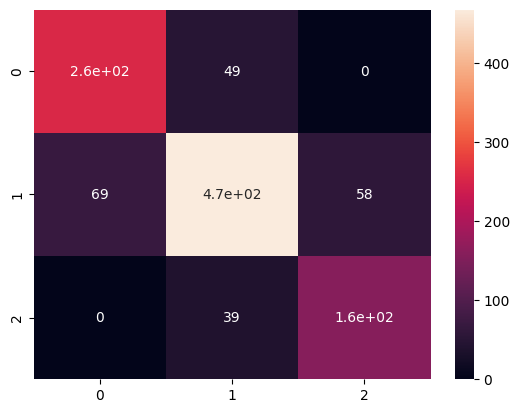

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [ ]:
confusion_matrix(y_test,y_pred)

array([[255,  49,   0],
       [ 69, 467,  58],
       [  0,  39, 157]])

In [ ]:
pipeline=Pipeline([
   ('preprocessor',preprocessor),
    #('target_preprocessor',target_preprocessor),
   ('xgbClassifier',xgb.XGBRFClassifier(n_estimators=150,min_samples_leaf=1,max_depth=25,criterion='mse'))
])




34555    1.0
4442     1.0
50811    1.0
45326    1.0
57679    2.0
        ... 
31019    1.0
44566    2.0
95816    1.0
72173    1.0
89256    0.0
Name: Credit_Score, Length: 80000, dtype: float64

In [ ]:
pipeline.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:04:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion", "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['Customer_ID', 'Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Out...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=25,
                                 max_leaves=None, min_child_weight=None,
                                 min_samples_leaf=1, missing=nan,
                                 monotone_constraints=None, multi_strategy=None,
                                 n_estimators=150, n_jobs=None,
                                 num_parallel_tree=None,
                                 objective='multi:softprob', ...))])

In [ ]:
y_pred=pipeline.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.8136

In [ ]:
feature_importance = pipeline.named_steps['xgbClassifier'].feature_importances_
feature_importance[::-1]

array([0.01209532, 0.01326563, 0.01323731, 0.01371576, 0.01391174,
       0.01456785, 0.01372619, 0.01360838, 0.01365751, 0.01349401,
       0.01324033, 0.01312377, 0.01432131, 0.01477967, 0.01409853,
       0.01295892, 0.01124186, 0.0184534 , 0.3941438 , 0.01503785,
       0.00998473, 0.06315975, 0.01564284, 0.01946939, 0.02013689,
       0.02318712, 0.01488812, 0.04922238, 0.04326024, 0.02320897,
       0.01583022, 0.01303779, 0.01157867, 0.01071031, 0.01000346],
      dtype=float32)

In [115]:
df=data[['Customer_ID', 'Month', 'Age', 'Occupation', 'Monthly_Inhand_Salary',
                'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan',
                'Delay_from_due_date', 'Changed_Credit_Limit', 'Outstanding_Debt',
                'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour','Credit_Score']]

df.shape

(150000, 15)

In [145]:
def traintest_split(data):

    x=data[~data['Credit_Score'].isna()].drop(columns='Credit_Score')
    y=data['Credit_Score'][~data['Credit_Score'].isna()]
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)
    x_test1=data[data['Credit_Score'].isna()].drop(columns='Credit_Score')
    y_test1=data['Credit_Score'][data['Credit_Score'].isna()]
    print(f"x_train: {x_train.shape} ",f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape} ",f"y_test: {y_test.shape}")
    print(f"x_test1: {x_test1.shape} ",f"y_test1: {y_test1.shape}")
    return (x_train,x_test,y_train,y_test,x_test1,y_test1)

In [146]:
x_train,x_test,y_train,y_test,x_test1,y_test1=traintest_split(df)


x_train: (80000, 14)  x_test: (20000, 14)
y_train: (80000,)  y_test: (20000,)
x_test1: (50000, 14)  y_test1: (50000,)


In [147]:
num_cols=df.select_dtypes(exclude='O').columns
cat_cols=df.select_dtypes(include='O').columns
num_cols[:-1],cat_cols

(Index(['Customer_ID', 'Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
        'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date',
        'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_History_Age'],
       dtype='object'),
 Index(['Month', 'Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour'], dtype='object'))

In [150]:
x_train['Month'].value_counts()

June        10070
February    10044
May         10014
April       10011
March       10006
July         9985
January      9952
August       9918
Name: Month, dtype: int64

In [151]:
def transform_payment_of_min_amount_column(column):
    return column.replace({'Yes': 1, 'No': 0, 'NM': 2}).astype('float')

def transform_payment_behaviour(column):
    return column.replace({'Low_spent_Small_value_payments':1, 'Low_spent_Medium_value_payments':2,
    'Low_spent_Large_value_payments':3, 'High_spent_Small_value_payments':4,
    'High_spent_Medium_value_payments':5, 'High_spent_Large_value_payments':6}).astype('float')

def transform_month(column):
    return column.replace({
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }).astype('float')

In [120]:
x_train['Payment_of_Min_Amount'].value_counts()

1.0    41820
0.0    28566
2.0     9614
Name: Payment_of_Min_Amount, dtype: int64

In [152]:
def transform_payment_of_min_amount_column(column):
    return column.replace({'Yes': 1, 'No': 0, 'NM': 2}).astype('float')

def transform_payment_behaviour(column):
    return column.replace({'Low_spent_Small_value_payments':1, 'Low_spent_Medium_value_payments':2,
    'Low_spent_Large_value_payments':3, 'High_spent_Small_value_payments':4,
    'High_spent_Medium_value_payments':5, 'High_spent_Large_value_payments':6}).astype('float')

def transform_month(column):
    return column.replace({
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }).astype('float')


preprocessor = ColumnTransformer(
    transformers=[
        ('transform_payment_of_min_amount_column',FunctionTransformer(transform_payment_of_min_amount_column, validate=False),['Payment_of_Min_Amount']),
        ('transform_payment_behaviour',FunctionTransformer(transform_payment_behaviour, validate=False),['Payment_Behaviour']),
        ('transform_month',FunctionTransformer(transform_month, validate=False),['Month']),
        ('num', MinMaxScaler(), num_cols[:-1]),  # Apply numerical pipeline to numerical features
        ('ohe', OneHotEncoder(drop='first',sparse_output=False), ['Occupation']) # Apply categorical pipeline to categorical features
    ],remainder='passthrough',verbose_feature_names_out=False)

pipeline=Pipeline([
   ('preprocessor',preprocessor),
   ('xgbClassifier',xgb.XGBRFClassifier(n_estimators=150,min_samples_leaf=1,max_depth=25,criterion='mse'))
])



In [123]:
df['Month']=df['Month'].replace({
        1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June',
        7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'
    })

<ipython-input-123-0f7ac6148981>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month']=df['Month'].replace({


In [153]:
df['Month'].value_counts()

January      12500
February     12500
March        12500
April        12500
May          12500
June         12500
July         12500
August       12500
September    12500
October      12500
November     12500
December     12500
Name: Month, dtype: int64

In [125]:
df['Payment_of_Min_Amount']=df['Payment_of_Min_Amount'].replace({1:'Yes',0:'No',2:'NM'})

<ipython-input-125-a15fd4a424e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Payment_of_Min_Amount']=df['Payment_of_Min_Amount'].replace({1:'Yes',0:'No',2:'NM'})


In [154]:
df['Payment_of_Min_Amount'].value_counts()

Yes    78484
No     53516
NM     18000
Name: Payment_of_Min_Amount, dtype: int64

In [127]:
df['Payment_Behaviour']=df['Payment_Behaviour'].replace({1:'Low_spent_Small_value_payments', 2:'Low_spent_Medium_value_payments',
    3:'Low_spent_Large_value_payments', 4:'High_spent_Small_value_payments',
    5:'High_spent_Medium_value_payments', 6:'High_spent_Large_value_payments'})

<ipython-input-127-ade3c663083b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Payment_Behaviour']=df['Payment_Behaviour'].replace({1:'Low_spent_Small_value_payments', 2:'Low_spent_Medium_value_payments',


In [157]:
df['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      43460
High_spent_Medium_value_payments    28664
Low_spent_Medium_value_payments     21970
High_spent_Large_value_payments     21957
High_spent_Small_value_payments     17679
Low_spent_Large_value_payments      16270
Name: Payment_Behaviour, dtype: int64

In [170]:
df.to_csv('df.csv')

In [171]:
df.shape

(150000, 15)

In [160]:
x_train['Month'].value_counts()

June        10070
February    10044
May         10014
April       10011
March       10006
July         9985
January      9952
August       9918
Name: Month, dtype: int64

In [161]:
pipeline.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:09:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion", "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transform_payment_of_min_amount_column',
                                                  FunctionTransformer(func=<function transform_payment_of_min_amount_column at 0x7ec2e75f80d0>),
                                                  ['Payment_of_Min_Amount']),
                                                 ('transform_payment_behaviour',
                                                  FunctionTransformer(func=<function transform_payment_behaviour at 0x7ec2e7...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=25,
                                 max_leaves=None, min_child_weight=None,
                                 min_samples_leaf=1, missing=nan,
                                 monotone_constraints=None, multi_strategy=None,
                                 n_estimators=150, n_jobs=None,
                                 num_parallel_tree=None,
                                 objective='multi:softprob', ...))])

In [162]:
y_pred=pipeline.predict(x_test)

In [164]:
accuracy_score(y_test,y_pred)*100

81.89999999999999

In [79]:
df.head()

,Customer_ID,Month,Age,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,3392.0,January,23.0,Scientist,1824.843333,3.0,4.0,4.0,3.0,11.27,809.98,265.0,No,4.0,2.0
1,3392.0,February,23.0,Scientist,1824.843333,3.0,4.0,4.0,-1.0,11.27,809.98,270.0,No,3.0,2.0
2,3392.0,March,24.0,Scientist,1824.843333,3.0,4.0,4.0,3.0,11.27,809.98,267.0,No,2.0,2.0
3,3392.0,April,23.0,Scientist,1824.843333,3.0,4.0,4.0,5.0,6.27,809.98,268.0,No,1.0,2.0
4,3392.0,May,23.0,Scientist,1824.843333,3.0,4.0,4.0,6.0,11.27,809.98,269.0,No,5.0,2.0


In [165]:
test=(pd.DataFrame(data=[[3392.0,'April',23.0,'Scientist',1824.843333,
                 3.0,4.0,4.0,
                 3.0,11.27,809.98,
                 265.0,'No',4.0]],
                 columns=['Customer_ID', 'Month', 'Age', 'Occupation', 'Monthly_Inhand_Salary',
                'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan',
                'Delay_from_due_date', 'Changed_Credit_Limit', 'Outstanding_Debt',
                'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']))

In [166]:
test

,Customer_ID,Month,Age,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour
0,3392.0,April,23.0,Scientist,1824.843333,3.0,4.0,4.0,3.0,11.27,809.98,265.0,No,4.0


In [167]:
pipeline.predict(test)

array([2])

In [168]:
import joblib
import pickle
with open('pipeline1.pkl', 'wb') as f:
    pickle.dump(pipeline, f)